# Xception model for cloud classification
Karla Baričević


In [14]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import cv2
import json


### Data preparation
#### Data info
2543 images of size 400x400

11 classes of cca 200 images each

- Ci = cirrus
- Cs = cirrostratus
- Cc = cirrocumulus
- Ac = altocumulus 
- As = altostratus
- Cu = cumulus
- Cb = cumulonimbus
- Ns = nimbostratus;
- Sc = stratocumulus
- St = stratus
- Ct = contrail

In [15]:
# Hiperparameters
path_to_data = "C:/Users/karla/Documents/Karlafaks/cloud_dataset/CCSN_v2"
img_size = 128

train_test_split = 0.7
batch_size = 64

epochs = 10
learning_rate = 0.001


In [16]:
dataset = ImageFolder(path_to_data, transform=
                                        transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]))

# dataset with augmentation to get more images
dataset_augmented = ImageFolder(path_to_data, transform= 
                                        transforms.Compose([transforms.Resize((img_size,img_size)), 
                                                            transforms.RandomHorizontalFlip(p=1),
                                                            transforms.RandomRotation(20),
                                                            transforms.ToTensor()]))

dataset = torch.utils.data.ConcatDataset([dataset, dataset_augmented])
dataset.classes = dataset_augmented.classes
dataset.targets = dataset_augmented.targets

if 1:
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Classes: {dataset.classes}")
    print("Samples per class:")
    for i in range(len(dataset.classes)):
        print(f"{dataset.classes[i]}: {dataset.targets.count(i)}")

Number of samples: 5086
Number of classes: 11
Classes: ['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']
Samples per class:
Ac: 221
As: 188
Cb: 242
Cc: 268
Ci: 139
Cs: 287
Ct: 200
Cu: 182
Ns: 274
Sc: 340
St: 202


In [17]:
# Split dataset into train and test

train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


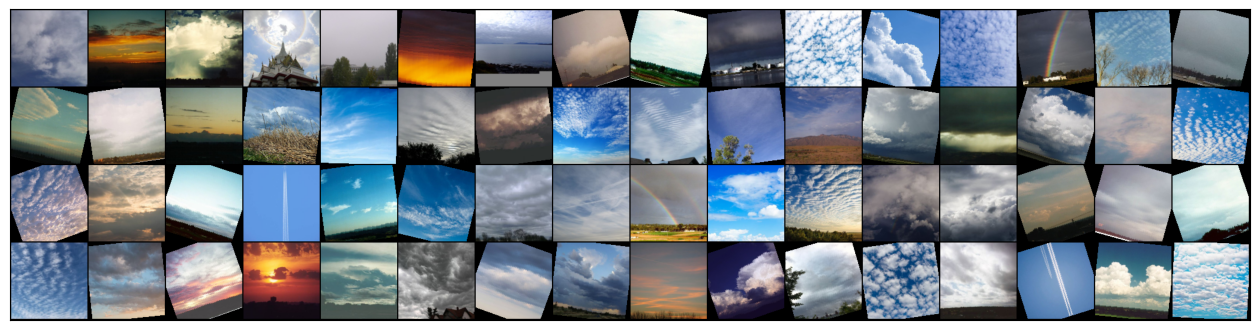

In [18]:

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

### Model architecture

In [24]:
# Define Xception Model
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()

        # Define skip connection
        if out_filters != in_filters or strides != 1:
            self.skip = nn.Conv2d(in_filters, out_filters, 1, stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        # Main convolutional path
        filters = in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for _ in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        # Diagnostic print statements        
        res = x
        if self.skip is not None:
            res = self.skip(x)
            res = self.skipbn(res)
        out = self.rep(x)
        
        # Ensure compatibility of sizes before addition
        if out.size() != res.size():
            raise RuntimeError(f"Shape mismatch: rep={out.size()}, skip={res.size()}")

        return out + res


class Xception(nn.Module):
    def __init__(self, num_classes):
        super(Xception, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.block1 = Block(64, 128, 2, 2, False, True)
        self.block2 = Block(128, 256, 2, 2, True, True)
        self.block3 = Block(256, 728, 2, 2, True, True)
        self.middle_blocks = nn.Sequential(*[Block(728, 728, 3, 1, True, True) for _ in range(8)])
        self.exit_block = Block(728, 1024, 2, 2, True, False)

        self.conv3 = SeparableConv2d(1024, 1536, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.conv4 = SeparableConv2d(1536, 2048, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(2048)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.middle_blocks(x)
        x = self.exit_block(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return self.fc(x)

# Model, Loss, Optimizer
num_classes = len(dataset.datasets[0].classes)
model = Xception(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss, correct = 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return epoch_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate(model, test_loader, criterion):
    model.eval()
    epoch_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return epoch_loss / len(test_loader), correct / len(test_loader.dataset)


### Model training

In [25]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/10, Train Loss: 2.1113, Train Acc: 0.2767, Test Loss: 2.1482, Test Acc: 0.2379
Epoch 2/10, Train Loss: 1.9225, Train Acc: 0.3228, Test Loss: 2.1850, Test Acc: 0.2641
Epoch 3/10, Train Loss: 1.8400, Train Acc: 0.3711, Test Loss: 1.9367, Test Acc: 0.3342
Epoch 4/10, Train Loss: 1.7613, Train Acc: 0.3904, Test Loss: 2.0809, Test Acc: 0.3565
Epoch 5/10, Train Loss: 1.6563, Train Acc: 0.4230, Test Loss: 2.2047, Test Acc: 0.3375
Epoch 6/10, Train Loss: 1.5815, Train Acc: 0.4486, Test Loss: 1.9196, Test Acc: 0.3453
Epoch 7/10, Train Loss: 1.4893, Train Acc: 0.4739, Test Loss: 1.8286, Test Acc: 0.3853
Epoch 8/10, Train Loss: 1.3932, Train Acc: 0.5084, Test Loss: 2.1164, Test Acc: 0.3388
Epoch 9/10, Train Loss: 1.3282, Train Acc: 0.5362, Test Loss: 1.8653, Test Acc: 0.3991
Epoch 10/10, Train Loss: 1.2322, Train Acc: 0.5660, Test Loss: 1.6999, Test Acc: 0.4305


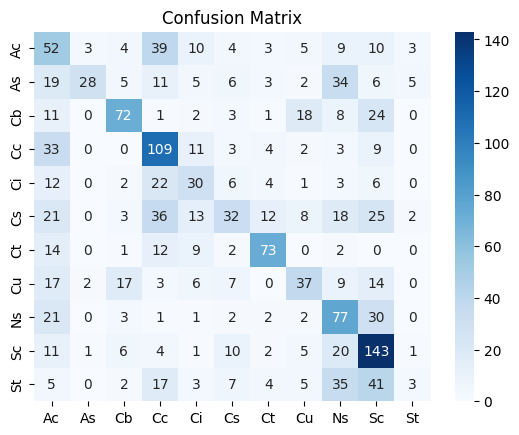

In [27]:
# Confusion Matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.datasets[0].classes, yticklabels=dataset.datasets[0].classes)
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=dataset.datasets[0].classes))


              precision    recall  f1-score   support

          Ac       0.24      0.37      0.29       142
          As       0.82      0.23      0.35       124
          Cb       0.63      0.51      0.56       140
          Cc       0.43      0.63      0.51       174
          Ci       0.33      0.35      0.34        86
          Cs       0.39      0.19      0.25       170
          Ct       0.68      0.65      0.66       113
          Cu       0.44      0.33      0.38       112
          Ns       0.35      0.55      0.43       139
          Sc       0.46      0.70      0.56       204
          St       0.21      0.02      0.04       122

    accuracy                           0.43      1526
   macro avg       0.45      0.41      0.40      1526
weighted avg       0.45      0.43      0.41      1526

